# GREEN HACKENBUSH
## Introduction
Green Hackenbush is an impartial Two-Player Zero-Sum combinatorial game.  
It is played on any configuration of green line segments connected to one another by their endpoints and to a "ground" line.  
The rules of the game are as follows:
1. Two players take turns cutting edges on a connected rooted graph or a collection of connected rooted graphs.
2. When a player cuts an edge, it disappears along with any edges that are no longer connected to the ground.
3. The player who is not able to make a move in their turn is declared as the loser of the game.

Green Hackenbush is **polynomial time solvable**.

## Game Values
Each independent connected component can be reduced to a **stalk/rod** by following a set of rules. Each stalk is then equivalent to a *nim heap* and is assigned a *nimber*. The final result of the game depends on the *XOR-Sum* of every nimber. The first player wins if the *XOR-Sum* is positive, otherwise, the second player wins. 


In [148]:
'''Code Setup'''
%config IPCompleter.greedy=True
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout, to_agraph
import matplotlib.pyplot as plt
from copy import deepcopy
class Graph:
    def __init__(self):
        self.nodecolors = {}
        self.G = nx.DiGraph()
        self.counter=0
        self.roots=[]
    
    def drawGraph(self):
        plt.gca().invert_yaxis()
        pos =graphviz_layout(self.G, prog='dot')
        edges = self.G.edges()
        colors = [self.nodecolors[u][v] for u,v in edges]
        nx.draw(self.G, pos, with_labels=False, arrows=False, edge_color=colors, node_color='black', width=5)
        plt.show()

    def add_edge(self, From, To, color='black'):
        self.G.add_edge(From,To)
        if From in self.nodecolors:
            self.nodecolors[From][To] = color
        else:
            self.nodecolors[From] = {To:color}
    
    def remove_node(self,node):
        if node in self.G.nodes():
            nodes = deepcopy(self.G[node])
            for v in nodes:
                self.remove_edge(node,v)
            self.G.remove_node(node)
        
    
    def remove_edge(self,From,To):
        if From in self.G and To in self.G[From]:
            self.G.remove_edge(From,To)
            self.nodecolors[From].pop(To,None)
            self.remove_node(To)
        


In [175]:
''' Core Reduction Code'''
def change_color(G,node,col):
    for child in G.G[node]:
        G.nodecolors[node][child]=col
        change_color(G,child,col)   
        
def add_chain(G,node,length,color='grey'):
    if(length==0):
        return
    G.add_edge(node,G.counter,color)
    G.counter+=1
    add_chain(G,G.counter-1,length-1,color)
    
def dfs(G,node):
    if len(G.G[node])==0:
        return 1
    sz=0
    xor_value=0
    for child in G.G[node]:
        chain_len=dfs(G,child)
        sz+=chain_len
        xor_value^=chain_len
    if len(G.G[node])==1:
        return sz+1
    G.drawGraph()
    change_color(G,node,'purple')
    G.drawGraph()
    adj_list=deepcopy(G.G[node])
    for child in adj_list:
        G.remove_edge(node,child)
    if xor_value==0:
        return 1
    add_chain(G,node,xor_value)
    G.drawGraph()
    change_color(G,node,'g')
    return xor_value+1

def reduce_stalks(G):
    xor_value=0
    for root in G.roots:
        val=len(list(nx.dfs_edges(G.G,root)))
        xor_value^=val
        change_color(G,root,'purple')
    G.drawGraph() 
    temproot=deepcopy(G.roots)
    for root in temproot:
        G.remove_node(root)
        G.roots.remove(root)
    G.counter+=1
    G.roots.append(G.counter-1)
    if(xor_value==0):
        print()
        G.add_edge(0,0)
        G.drawGraph()
        return
    add_chain(G,G.counter-1,xor_value)
    G.drawGraph()    
    change_color(G,G.roots[0],'g')
    G.drawGraph()   

def reduce_board(G):
    for root in G.roots:
        dfs(G,root)
    G.drawGraph()
    if len(G.roots)<=1:
        return
    reduce_stalks(G)
    

In [167]:
'''Board Generator Code'''

def dfs_add(G,node,ans,parent):
    for child in G[node]:
        if child==parent:
            continue
        ans.add_edge(node+ans.counter,child+ans.counter,'g')
        dfs_add(G,child,ans,node)
        
def convert_graph(G,ans):
    ans.roots.append(ans.counter)
    dfs_add(G,0,ans,-1)
    ans.counter+=len(G.node())
    
def get_forest(nlist):
    ans=Graph()
    for i in nlist:
        convert_graph(nx.random_tree(i),ans)
    return ans

def get_stalks(nlist):
    ans=Graph()
    for i in nlist:
        root=ans.counter
        ans.roots.append(root)
        ans.counter+=1
        add_chain(ans,root,i,color='green')
    return ans

## Example
The following snippet demonstrates the reduction of a single tree into a stalk.  
Purple edges indicate **deletion**.  
Grey edges indicate **addition**.


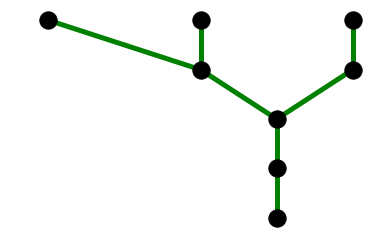

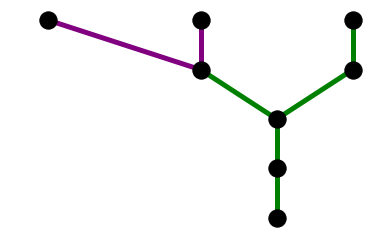

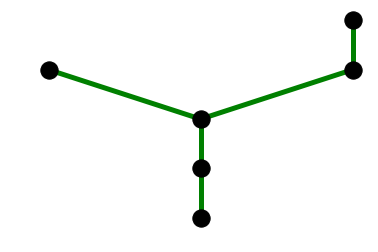

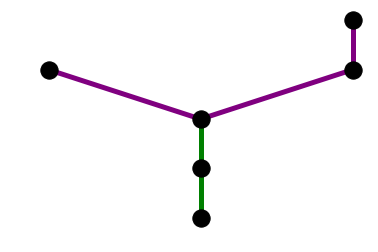

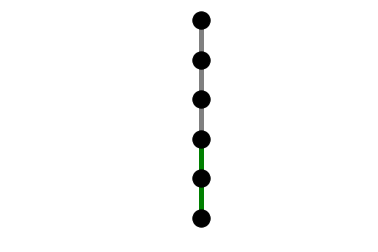

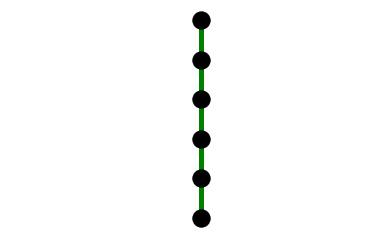

In [177]:
G = get_forest([8])            
reduce_board(G)

## Part I: Stalk Green Hackenbush

The Stalk Green Hackenbush is a case of the game where each connected component is a stalk.  
Example:

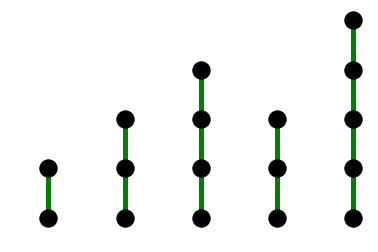

In [179]:
example_stalks=get_stalks([1,2,3,2,4])
example_stalks.drawGraph()

## Calculating the Value of the Board

Let us consider a single stalk with $N$ edges. The player can reduce the number of edges in this stalk to any value in the range $[0,N-1]$. It is not possible to remain with $N$ edges since the player is required to make a move in their turn.   
This is equivalent to a Nim-game having a single pile of $N$ stones.  

We can now equate a multi-stalk Green Hackenbush Game to a multi-pile Nim-Game.  

Following from the theory of Nim-Game, each stalk is assigned a **nimber** with its value equivalent to the number of edges in the stalk.  

All of the stalks can then be merged into a single stalk having its **nimber** equivalent to the **XOR-Sum** of the **nimbers** of the individual stalks.

Example:

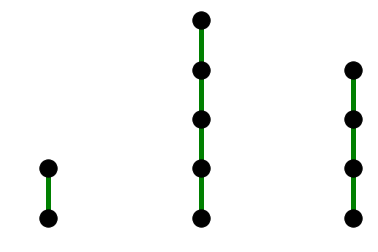

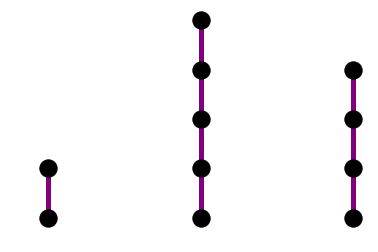

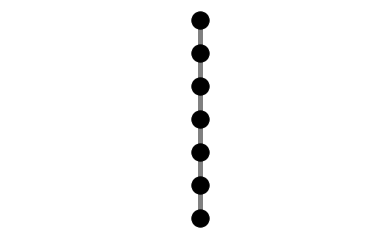

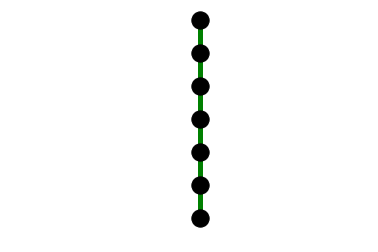

In [181]:
multi_stalk_example=get_stalks([1,4,3])
reduce_board(multi_stalk_example)

| Stalk Index | Edges   | Nimber |
|------|------|-----|
|   1  | 1|1|
|2|4|4|
|3|3|3|

Nimber of merged stalk $ = 1 \oplus 4 \oplus 3 = 6 $

Thus the orginal board containing three stalks of sizes $[1,4,3]$ is equivalent to a board containing a single stalk of size $6$. 

The first player can **always win** if the final nimber is positive. This is because he can reduce the number of edges in his turn to zero, leaving the second player with no moves left to make. 

On the otherhand, if the final nimber if zero, the second player can **always win**.

An example of a game which the second player can win:

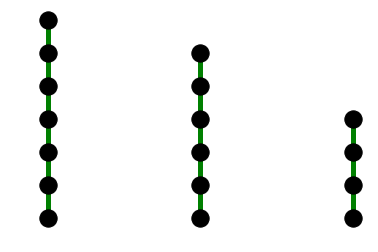

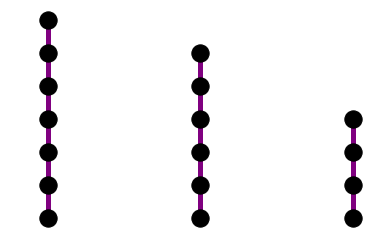

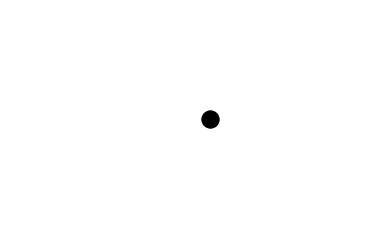

In [182]:
second_player_win=get_stalks([6,5,3])
reduce_board(second_player_win)

In the above example, the final nimber $ = 6 \oplus 5 \oplus 3 = 0$.

## Part II: Tree Green-Hackenbush

In this case of the Green Hackenbush, each connected component on the board is a **tree**.   
A *tree* is an undirected graph $G$ consisting of $n$ vertices and satisfying the following condition:
+ $G$ is connected.
+ $G$ has no cycles.
+ $G$ has exactly n-1 edges.

An example board consisting of independent trees:

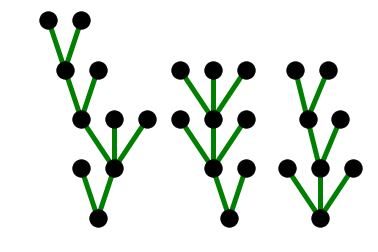

In [193]:
example_tree=get_forest([10,9,8])
example_tree.drawGraph()

If it were possible to reduce each tree into a stalk, then we can convert it into *Stalk Green-Hackenbush* and solve it using the methond mentioned in *Part I*. 

**We claim that it is possible to reduce each tree into a stalk**.

## Reduction of Tree into Stalk

To reduce a tree into a stalk, we must first know the **colon principle**.
 - - -
### Colon Principle
The Colon Principle states that when stalks come together at a vertex, one may replace all the stalks by a non-branching stalk having edges equal to their nim sum.

**Reasoning:** Consider stalks which together at the root. When a player removes an edge from either of the stalk, the others are not affected.   
Infact, we can consider each stalk to be independent of all the others.     
Now, we know from *Part I* that the equivalent stalk of a collection of disjoint stalks has edges equal to the *nim-sum* of the disjoint stalks.

Consider the following example:

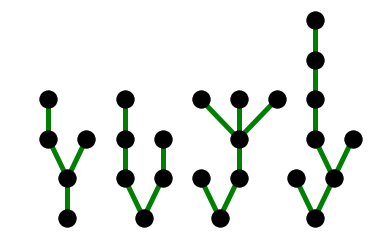

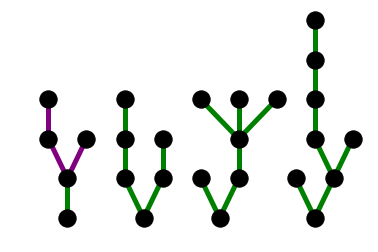

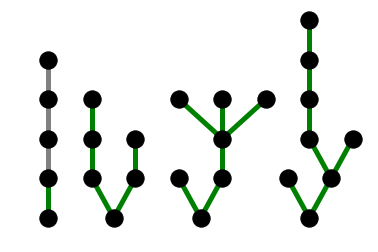

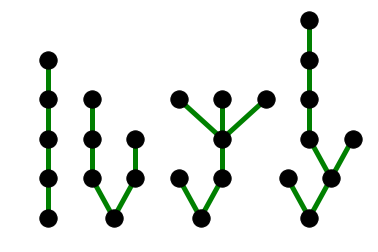

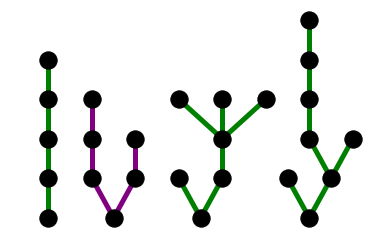

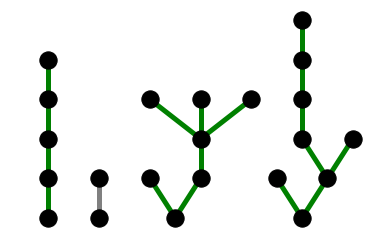

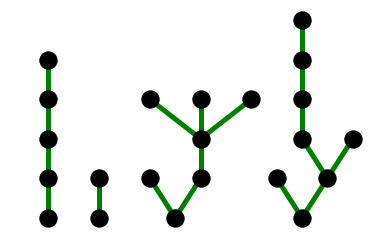

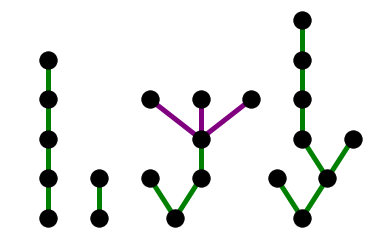

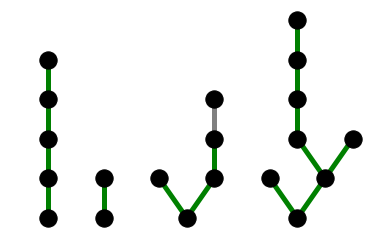

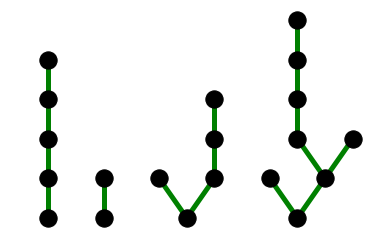

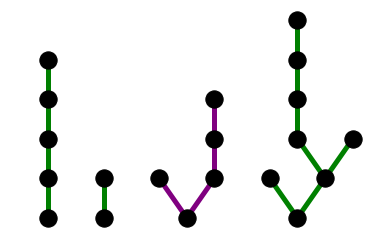

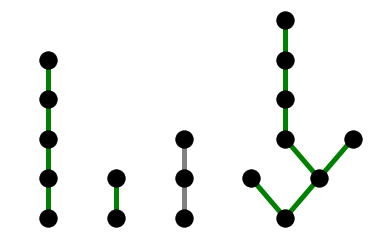

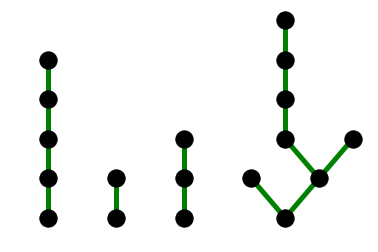

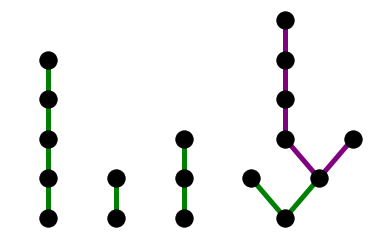

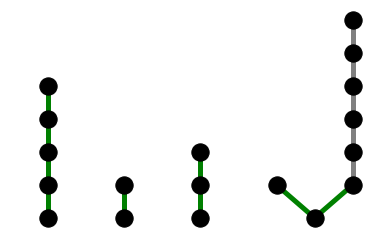

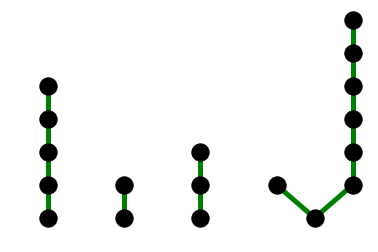

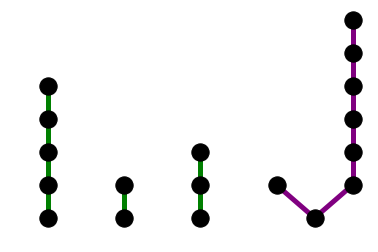

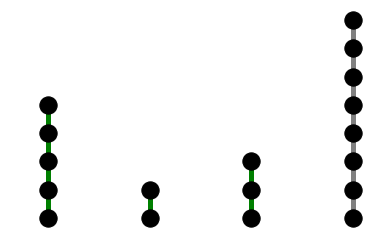

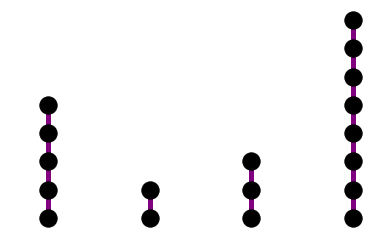

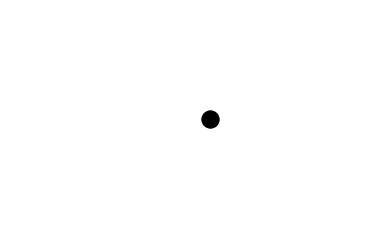

In [141]:


rt1=get_forest([5,6,7,8])
for root in rt1.roots:
    dfs(rt1,root)
reduce_stalks(rt1)

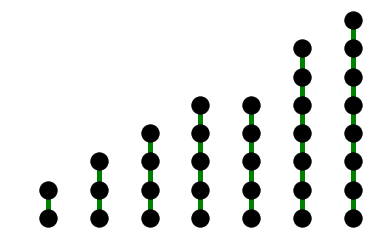

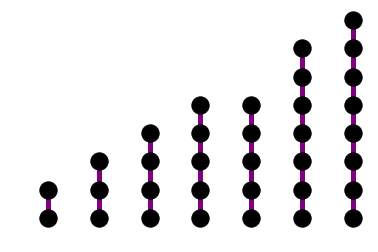

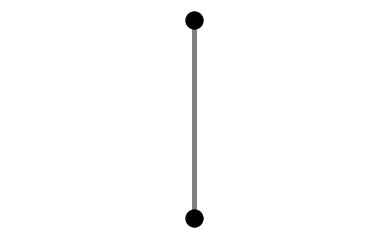

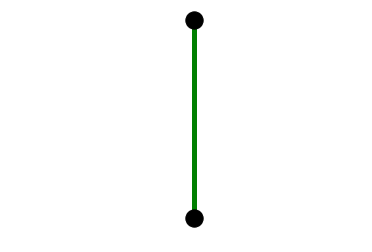

In [145]:

        
rt2=get_stalks([1,2,3,4,4,6,7])
rt2.drawGraph()
reduce_stalks(rt2)